
# Lab1 Task1：從零實作 MLP 訓練 MNIST（No CNN）

本 Notebook 依作業要求實作：  
- **NN Layer**：`Linear / ReLU / Sigmoid / Softmax(+CrossEntropy)`，含 Forward/Backward。  
- **MNIST 訓練設定**：集中參數配置、**Cross-Validation**（train/valid 或 K-Fold）。  
- **自訂 MLP**（至少一層 Hidden Layer）。  
- **繪製 Training/Validation Loss & Accuracy 圖**。  




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/AI_lab/Lab1\ Material

/content/drive/MyDrive/AI_lab/Lab1 Material


In [3]:

# === 匯入與參數 ===
import os, math, json
import numpy as np
import matplotlib.pyplot as plt

CONFIG = {
    "seed": 42,
    "data_normalize": True,
    "zscore": False,
    "validation_split": 0.1,
    "k_folds": 1,
    "num_epochs": 20,
    "batch_size": 128,
    "lr": 0.1,
    "momentum": 0.9,
    "weight_decay": 1e-4,
    "hidden_dims": [256, 128],
    "activation": "relu",
    "artifacts_dir": "./artifacts",
    "save_logs_csv": True,
    "log_csv_path": "./artifacts/training_log.csv",
    "plot_path": "./artifacts/training_curves.png",
    "use_nesterov": False,
}
os.makedirs(CONFIG["artifacts_dir"], exist_ok=True)

def set_seed(seed: int = 42):
    np.random.seed(seed)

def one_hot(y: np.ndarray, num_classes: int) -> np.ndarray:
    out = np.zeros((y.shape[0], num_classes), dtype=np.float32)
    out[np.arange(y.shape[0]), y] = 1.0
    return out

def accuracy(pred_logits: np.ndarray, y_true: np.ndarray) -> float:
    preds = np.argmax(pred_logits, axis=1)
    return float(np.mean(preds == y_true))

def train_val_split(X, y, val_ratio=0.1, seed=42):
    n = X.shape[0]
    rng = np.random.default_rng(seed)
    idx = np.arange(n); rng.shuffle(idx)
    n_val = int(n * val_ratio)
    val_idx = idx[:n_val]; train_idx = idx[n_val:]
    return (X[train_idx], y[train_idx]), (X[val_idx], y[val_idx])

def kfold_indices(n_samples: int, k: int, seed: int = 42):
    rng = np.random.default_rng(seed)
    idx = np.arange(n_samples); rng.shuffle(idx)
    folds = np.array_split(idx, k)
    return folds


## 載入 MNIST（多來源 fallback）

In [4]:

def load_mnist():
    """
    回傳：X_train (N, 784), y_train (N,), X_test (N2, 784), y_test (N2,)
    優先使用順序：keras -> sklearn openml -> 當前目錄 mnist.npz
    """
    # 1) keras
    try:
        from tensorflow.keras.datasets import mnist as keras_mnist  # type: ignore
        (x_train, y_train), (x_test, y_test) = keras_mnist.load_data()
        X_train = x_train.reshape(-1, 28*28).astype(np.float32)
        X_test  = x_test.reshape(-1, 28*28).astype(np.float32)
        return X_train, y_train.astype(np.int64), X_test, y_test.astype(np.int64)
    except Exception as e:
        print("[load_mnist] keras 下載失敗或不可用：", e)

    # 2) sklearn (需網路)
    try:
        from sklearn.datasets import fetch_openml  # type: ignore
        mnist = fetch_openml('mnist_784', version=1, as_frame=False)
        X = mnist['data'].astype(np.float32)
        y = mnist['target'].astype(np.int64)
        return X[:60000], y[:60000], X[60000:], y[60000:]
    except Exception as e:
        print("[load_mnist] sklearn openml 失敗：", e)

    # 3) 本地 mnist.npz（Keras 版）
    local_npz = "mnist.npz"
    if os.path.exists(local_npz):
        with np.load(local_npz) as data:
            x_train, y_train = data["x_train"], data["y_train"]
            x_test, y_test   = data["x_test"], data["y_test"]
        return (x_train.reshape(-1, 784).astype(np.float32), y_train.astype(np.int64),
                x_test.reshape(-1, 784).astype(np.float32), y_test.astype(np.int64))

    raise RuntimeError("無法載入 MNIST；請將 keras 版 mnist.npz 放到此資料夾後再執行。")

def normalize_inputs(X: np.ndarray, use_zscore: bool = False) -> np.ndarray:
    X = X / 255.0
    if use_zscore:
        mean = X.mean(axis=0, keepdims=True)
        std = X.std(axis=0, keepdims=True) + 1e-6
        X = (X - mean) / std
    return X.astype(np.float32)

# 快測
try:
    Xtr_tmp, ytr_tmp, Xte_tmp, yte_tmp = load_mnist()
    print("MNIST 載入成功：", Xtr_tmp.shape, ytr_tmp.shape, Xte_tmp.shape, yte_tmp.shape)
except Exception as e:
    print(str(e))


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
MNIST 載入成功： (60000, 784) (60000,) (10000, 784) (10000,)


## Layers：Linear / ReLU / Sigmoid / SoftmaxCrossEntropy

In [ ]:

class Layer:
    def forward(self, x: np.ndarray) -> np.ndarray: raise NotImplementedError
    def backward(self, grad_out: np.ndarray) -> np.ndarray: raise NotImplementedError
    def params_and_grads(self): return []

class Linear(Layer):
    def __init__(self, in_features: int, out_features: int, weight_scale: float = None):
        if weight_scale is None:
            weight_scale = math.sqrt(2.0 / in_features)
        self.W = (np.random.randn(in_features, out_features).astype(np.float32) * weight_scale)
        self.b = np.zeros((1, out_features), dtype=np.float32)
        self.dW = np.zeros_like(self.W); self.db = np.zeros_like(self.b)
        self.cache_x = None

    def forward(self, x):
        self.cache_x = x
        return x @ self.W + self.b

    def backward(self, grad_out):
        x = self.cache_x
        self.dW[...] = x.T @ grad_out
        self.db[...] = np.sum(grad_out, axis=0, keepdims=True)
        return grad_out @ self.W.T

    def params_and_grads(self):
        yield self.W, self.dW
        yield self.b, self.db

class ReLU(Layer):
    def __init__(self): self.mask = None
    def forward(self, x):
        self.mask = (x > 0).astype(np.float32); return x * self.mask
    def backward(self, grad_out): return grad_out * self.mask

class Sigmoid(Layer):
    def __init__(self): self.out = None
    def forward(self, x):
        self.out = (1 / (1 + np.exp(-x))).astype(np.float32); return self.out
    def backward(self, grad_out): return grad_out * self.out * (1 - self.out)

class SoftmaxCrossEntropy:
    def __init__(self):
        self.logits = None; self.y_true = None; self.probs = None
    def forward(self, logits: np.ndarray, y_true: np.ndarray, weight_decay: float = 0.0, params_l2: float = 0.0) -> float:
        self.logits = logits; self.y_true = y_true
        shifted = logits - logits.max(axis=1, keepdims=True)
        exp = np.exp(shifted); probs = exp / np.sum(exp, axis=1, keepdims=True)
        self.probs = probs
        N = logits.shape[0]
        loss = -np.log(probs[np.arange(N), y_true] + 1e-12).mean()
        reg = weight_decay * params_l2 if weight_decay > 0 else 0.0
        return float(loss + reg)
    def backward(self) -> np.ndarray:
        N = self.logits.shape[0]
        grad = self.probs.copy()
        grad[np.arange(N), self.y_true] -= 1.0
        return (grad / N).astype(np.float32)


## Optimizer 與 MLP

In [6]:

class SGD:
    def __init__(self, params, lr=0.1, momentum=0.9, nesterov=False, weight_decay=0.0):
        self.lr = lr; self.momentum = momentum; self.nesterov = nesterov; self.weight_decay = weight_decay
        self.velocities = [np.zeros_like(p) for (p, g) in params]

    def step(self, params):
        for i, (p, g) in enumerate(params):
            if self.weight_decay > 0: g = g + self.weight_decay * p
            v = self.velocities[i]; v *= self.momentum; v += self.lr * g
            if self.nesterov: p -= self.momentum * v + self.lr * g
            else: p -= v

class MLP:
    def __init__(self, input_dim: int, hidden_dims, num_classes: int, activation="relu"):
        layers = []; prev = input_dim
        act_cls = ReLU if activation.lower() == "relu" else Sigmoid
        for h in hidden_dims:
            layers += [Linear(prev, h), act_cls()]
            prev = h
        layers += [Linear(prev, num_classes)]
        self.layers = layers
        self.criterion = SoftmaxCrossEntropy()

    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer.forward(out)
        return out

    def backward(self, grad_logits):
        grad = grad_logits
        for layer in reversed(self.layers):
            grad = layer.backward(grad)

    def params_and_grads(self):
        for layer in self.layers:
            for pair in layer.params_and_grads():
                yield pair

    def l2_params_sum(self) -> float:
        s = 0.0
        for layer in self.layers:
            for (p, _) in layer.params_and_grads():
                s += float(np.sum(p * p))
        return s


## 訓練 & 畫圖

In [7]:

def iterate_minibatches(X, y, batch_size, shuffle=True, seed=42):
    n = X.shape[0]; idx = np.arange(n)
    if shuffle:
        rng = np.random.default_rng(seed); rng.shuffle(idx)
    for s in range(0, n, batch_size):
        e = min(s + batch_size, n)
        b = idx[s:e]
        yield X[b], y[b]

def fit_once(model, X_train, y_train, X_val, y_val, config):
    logs = {"epoch": [], "train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    opt = SGD(list(model.params_and_grads()), lr=config["lr"], momentum=config["momentum"],
              nesterov=config["use_nesterov"], weight_decay=config["weight_decay"])
    for ep in range(1, config["num_epochs"] + 1):
        tr_loss = tr_acc = 0.0; n_tr = 0
        for xb, yb in iterate_minibatches(X_train, y_train, config["batch_size"], True, seed=config["seed"]+ep):
            logits = model.forward(xb)
            loss = model.criterion.forward(logits, yb, weight_decay=config["weight_decay"], params_l2=model.l2_params_sum())
            grad = model.criterion.backward()
            model.backward(grad)
            opt.step(list(model.params_and_grads()))
            tr_loss += loss * xb.shape[0]; tr_acc += accuracy(logits, yb) * xb.shape[0]; n_tr += xb.shape[0]
        train_loss = tr_loss / n_tr; train_acc = tr_acc / n_tr
        logits_val = model.forward(X_val)
        val_loss = model.criterion.forward(logits_val, y_val, weight_decay=config["weight_decay"], params_l2=model.l2_params_sum())
        val_acc = accuracy(logits_val, y_val)
        logs["epoch"].append(ep); logs["train_loss"].append(train_loss); logs["train_acc"].append(train_acc)
        logs["val_loss"].append(val_loss); logs["val_acc"].append(val_acc)
        print(f"[Epoch {ep:02d}] train_loss={train_loss:.4f} acc={train_acc*100:.2f}% | val_loss={val_loss:.4f} acc={val_acc*100:.2f}%")
    return logs

def plot_curves(logs, out_path):
    ep = logs["epoch"]
    plt.figure(figsize=(7,4)); plt.plot(ep, logs["train_loss"], label="Train Loss"); plt.plot(ep, logs["val_loss"], label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss"); plt.tight_layout()
    plt.savefig(out_path.replace(".png", "_loss.png"), dpi=150); plt.show()

    plt.figure(figsize=(7,4)); plt.plot(ep, [x*100 for x in logs["train_acc"]], label="Train Acc")
    plt.plot(ep, [x*100 for x in logs["val_acc"]], label="Val Acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.legend(); plt.title("Accuracy"); plt.tight_layout()
    plt.savefig(out_path.replace(".png", "_acc.png"), dpi=150); plt.show()

def save_logs_csv(logs, csv_path):
    import csv
    keys = ["epoch", "train_loss", "train_acc", "val_loss", "val_acc"]
    with open(csv_path, "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f); w.writerow(keys)
        rows = zip(*[logs[k] for k in keys])
        for r in rows: w.writerow(r)
    print("[csv] saved ->", csv_path)


## （A）單次 train/valid 訓練

[Epoch 01] train_loss=0.3438 acc=92.16% | val_loss=0.2452 acc=95.22%
[Epoch 02] train_loss=0.1943 acc=97.00% | val_loss=0.2142 acc=96.53%
[Epoch 03] train_loss=0.1666 acc=97.83% | val_loss=0.1912 acc=97.47%
[Epoch 04] train_loss=0.1509 acc=98.39% | val_loss=0.2033 acc=97.23%
[Epoch 05] train_loss=0.1401 acc=98.70% | val_loss=0.2061 acc=97.15%
[Epoch 06] train_loss=0.1325 acc=98.97% | val_loss=0.1871 acc=97.55%
[Epoch 07] train_loss=0.1271 acc=99.12% | val_loss=0.2007 acc=97.62%
[Epoch 08] train_loss=0.1214 acc=99.26% | val_loss=0.1838 acc=97.85%
[Epoch 09] train_loss=0.1146 acc=99.46% | val_loss=0.1924 acc=97.78%
[Epoch 10] train_loss=0.1097 acc=99.52% | val_loss=0.1826 acc=97.80%
[Epoch 11] train_loss=0.1033 acc=99.67% | val_loss=0.1742 acc=97.97%
[Epoch 12] train_loss=0.0984 acc=99.72% | val_loss=0.1797 acc=97.73%
[Epoch 13] train_loss=0.0930 acc=99.84% | val_loss=0.1577 acc=98.22%
[Epoch 14] train_loss=0.0852 acc=99.95% | val_loss=0.1572 acc=98.12%
[Epoch 15] train_loss=0.0806 acc=9

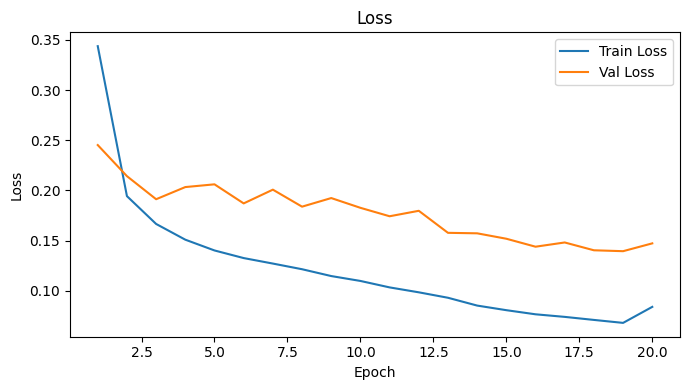

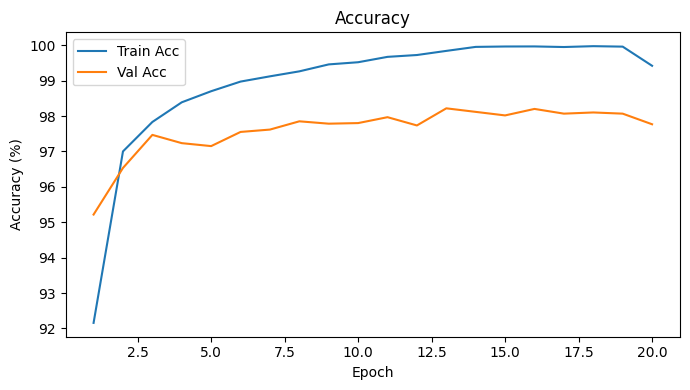

[TEST] loss=0.1302 acc=98.11%


In [8]:

set_seed(CONFIG["seed"])

X_train, y_train, X_test, y_test = load_mnist()
if CONFIG["data_normalize"]:
    X_train = normalize_inputs(X_train, CONFIG["zscore"])
    X_test  = normalize_inputs(X_test,  CONFIG["zscore"])

if CONFIG["k_folds"] <= 1:
    (X_tr, y_tr), (X_val, y_val) = train_val_split(X_train, y_train, CONFIG["validation_split"], CONFIG["seed"])
    model = MLP(input_dim=X_train.shape[1], hidden_dims=CONFIG["hidden_dims"], num_classes=10, activation=CONFIG["activation"])
    logs = fit_once(model, X_tr, y_tr, X_val, y_val, CONFIG)
    if CONFIG["save_logs_csv"]:
        save_logs_csv(logs, CONFIG["log_csv_path"])
    plot_curves(logs, CONFIG["plot_path"])

    # Test
    test_logits = model.forward(X_test)
    test_loss = model.criterion.forward(test_logits, y_test, weight_decay=CONFIG["weight_decay"], params_l2=model.l2_params_sum())
    test_acc = accuracy(test_logits, y_test)
    print(f"[TEST] loss={test_loss:.4f} acc={test_acc*100:.2f}%")
else:
    print("目前 CONFIG['k_folds'] > 1，請改跑下一節 K-Fold。")


## （B）K-Fold 交叉驗證

In [9]:

if CONFIG["k_folds"] > 1:
    folds = kfold_indices(X_train.shape[0], CONFIG["k_folds"], CONFIG["seed"])
    fold_accs = []
    for k, val_idx in enumerate(folds, start=1):
        train_idx = np.concatenate([folds[i] for i in range(len(folds)) if i != (k-1)])
        X_tr, y_tr = X_train[train_idx], y_train[train_idx]
        X_val, y_val = X_train[val_idx], y_train[val_idx]
        print(f"\n===== Fold {k}/{CONFIG['k_folds']} | train={X_tr.shape[0]} val={X_val.shape[0]} =====")
        model = MLP(input_dim=X_train.shape[1], hidden_dims=CONFIG["hidden_dims"], num_classes=10, activation=CONFIG["activation"])
        logs = fit_once(model, X_tr, y_tr, X_val, y_val, CONFIG)
        fold_accs.append(logs["val_acc"][-1])
    print("\n[K-Fold] mean val_acc =", np.mean(fold_accs)*100, "%")
